In [2]:
import torch
import torch.nn as nn
torch.cuda.is_available()
import numpy as np
from torch.optim.lr_scheduler import MultiStepLR
import time, PIL.Image, io, requests, copy
import matplotlib.pyplot as plt

In [6]:
data = np.genfromtxt(f'training/training_lab/maze1.txt', delimiter=' ')
print(np.shape(data))

(39, 39)


In [18]:
def get_dataset(filenumber: int, k=16):
    data = np.genfromtxt(f'training/training_lab/maze{filenumber}.txt', delimiter=' ')
    data = np.float32(data)/255.0
    data = data[None, None, :, :]
    data *= data[..., 3:]                          # premultiply RGB by alpha
    data = data.transpose(2,0,1)[None,...] 
    return {'y': np.pad(data, ((0,0),(0,0),(k,k),(k,k)))}

In [20]:
class CA(nn.Module):
    def __init__(self, state_dim=16, hidden_dim=128):
        super(CA, self).__init__()
        self.state_dim = state_dim
        self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
        self.update[-1].weight.data *= 0  # initial residual updates should be close to zero

        # First conv layer will use fixed Sobel filters to perceive neighbors
        identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
        kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
        kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
        self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
        self.update[0].weight.requires_grad = False

    def forward(self, x, num_steps):
        alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
        frames = []
        for i in range(num_steps):
            alive_mask_pre = alive_mask(alpha=x[:,3:4])
            update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
            x = x + update_mask * self.update(x)                       # state update!
            x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
            frames.append(x.clone())
        return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps

def normalize_grads(model):  # makes training more stable, especially early on
    for p in model.parameters():
        p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, args, data):
    model = model.to(args.device)  # put the model on GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = MultiStepLR(optimizer, milestones=args.milestones, gamma=args.gamma)

    target_rgba = torch.Tensor(data['y']).to(args.device)  # put the target image on GPU
    init_state = torch.zeros(args.batch_size, args.state_dim, *target_rgba.shape[-2:]).to(args.device)
    init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.  # initially, there is just one cell
    pool = init_state[:1].repeat(args.pool_size,1,1,1)

    results = {'loss':[], 'tprev': [time.time()]}
    for step in range(args.total_steps+1):

# prepare batch, perturb, and run forward pass
        if args.pool_size > 0:  # draw CAs from pool (if we have one)
            pool_ixs = np.random.randint(args.pool_size, size=[args.batch_size])
            input_states = pool[pool_ixs]
        else:
            input_states = init_state

        states = model(input_states, np.random.randint(*args.num_steps))  # forward pass
        final_rgba = states[-1,:, :4]  # grab rgba channels of last frame

        # compute loss and run backward pass
        mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
        batch_mses = mses.view(args.batch_size,-1).mean(-1)
        loss = batch_mses.mean()
        loss.backward() ; normalize_grads(model)
        optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if args.pool_size > 0:
        final_states = states[-1].detach()
        final_states[batch_mses.argmax()] = init_state[:1]
        pool[pool_ixs] = final_states

# bookkeeping and logging
    results['loss'].append(loss.item())
    if step % args.print_every == 0:
        print('step {}, dt {:.3f}s, loss {:.2e}, log10(loss) {:.2f}'\
            .format(step, time.time()-results['tprev'][-1], loss.item(), np.log10(loss.item())))
        results['tprev'].append(time.time())

    results['final_model'] = copy.deepcopy(model.cpu())
    return results

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
def get_args(as_dict=False):
    arg_dict = {'state_dim': 16,        # first 4 are rgba, rest are latent
                'hidden_dim': 128,
                'num_steps': [64, 96],
                'pool_size': 0,         # pool of persistent CAs (defaults are 0 and 1000)
                'perturb_n': 0,         # num. of CAs to perturb (defaults are 0 and 3)
                'batch_size': 8,
                'learning_rate': 2e-3, 
                'milestones': [1500],   # lr scheduler milestones
                'gamma': 0.25,          # lr scheduler gamma
                'print_every': 10,
                'total_steps': 20,
                'device': 'cuda',       # options are {"cpu", "cuda"}
                'seed': 42}             # the meaning of life (for these little guys)
    return arg_dict if as_dict else ObjectView(arg_dict)           

In [21]:
import pickle
project_dir = "/code/"

def to_pickle(thing, path):  # save something
  with open(path, 'wb') as handle:
      pickle.dump(thing, handle, protocol=pickle.HIGHEST_PROTOCOL)

def from_pickle(path):  # load something
  thing = None
  with open(path, 'rb') as handle:
      thing = pickle.load(handle)
  return thing

In [23]:
configs = [{'pool_size': 0, 'perturb_n': 0, 'name': 'grow'}]

for config in configs:
  print("\n#### Training CA model '{}': pool_size: {}, perturb_n: {} ####"\
        .format(config['name'], config['pool_size'], config['perturb_n']))
  args = get_args()  # instantiate args, then everything else, then run
  args.pool_size = config['pool_size']
  args.perturb_n = config['perturb_n']
  [f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
  model = CA(args.state_dim, args.hidden_dim)
  results = train(model, args, data=get_dataset(filenumber=10))

  run_tag = 'ca_{}.pkl'.format(config['name'])
#   to_pickle(results, path=project_dir + run_tag)


#### Training CA model 'grow': pool_size: 0, perturb_n: 0 ####


ValueError: operands could not be broadcast together with shapes (1,1,39,39) (1,1,39,36) (1,1,39,39) 

In [16]:
results = from_pickle(path=project_dir + 'ca_persist.pkl')
model = results['final_model']

FileNotFoundError: [Errno 2] No such file or directory: '/code/modelca_persist.pkl'

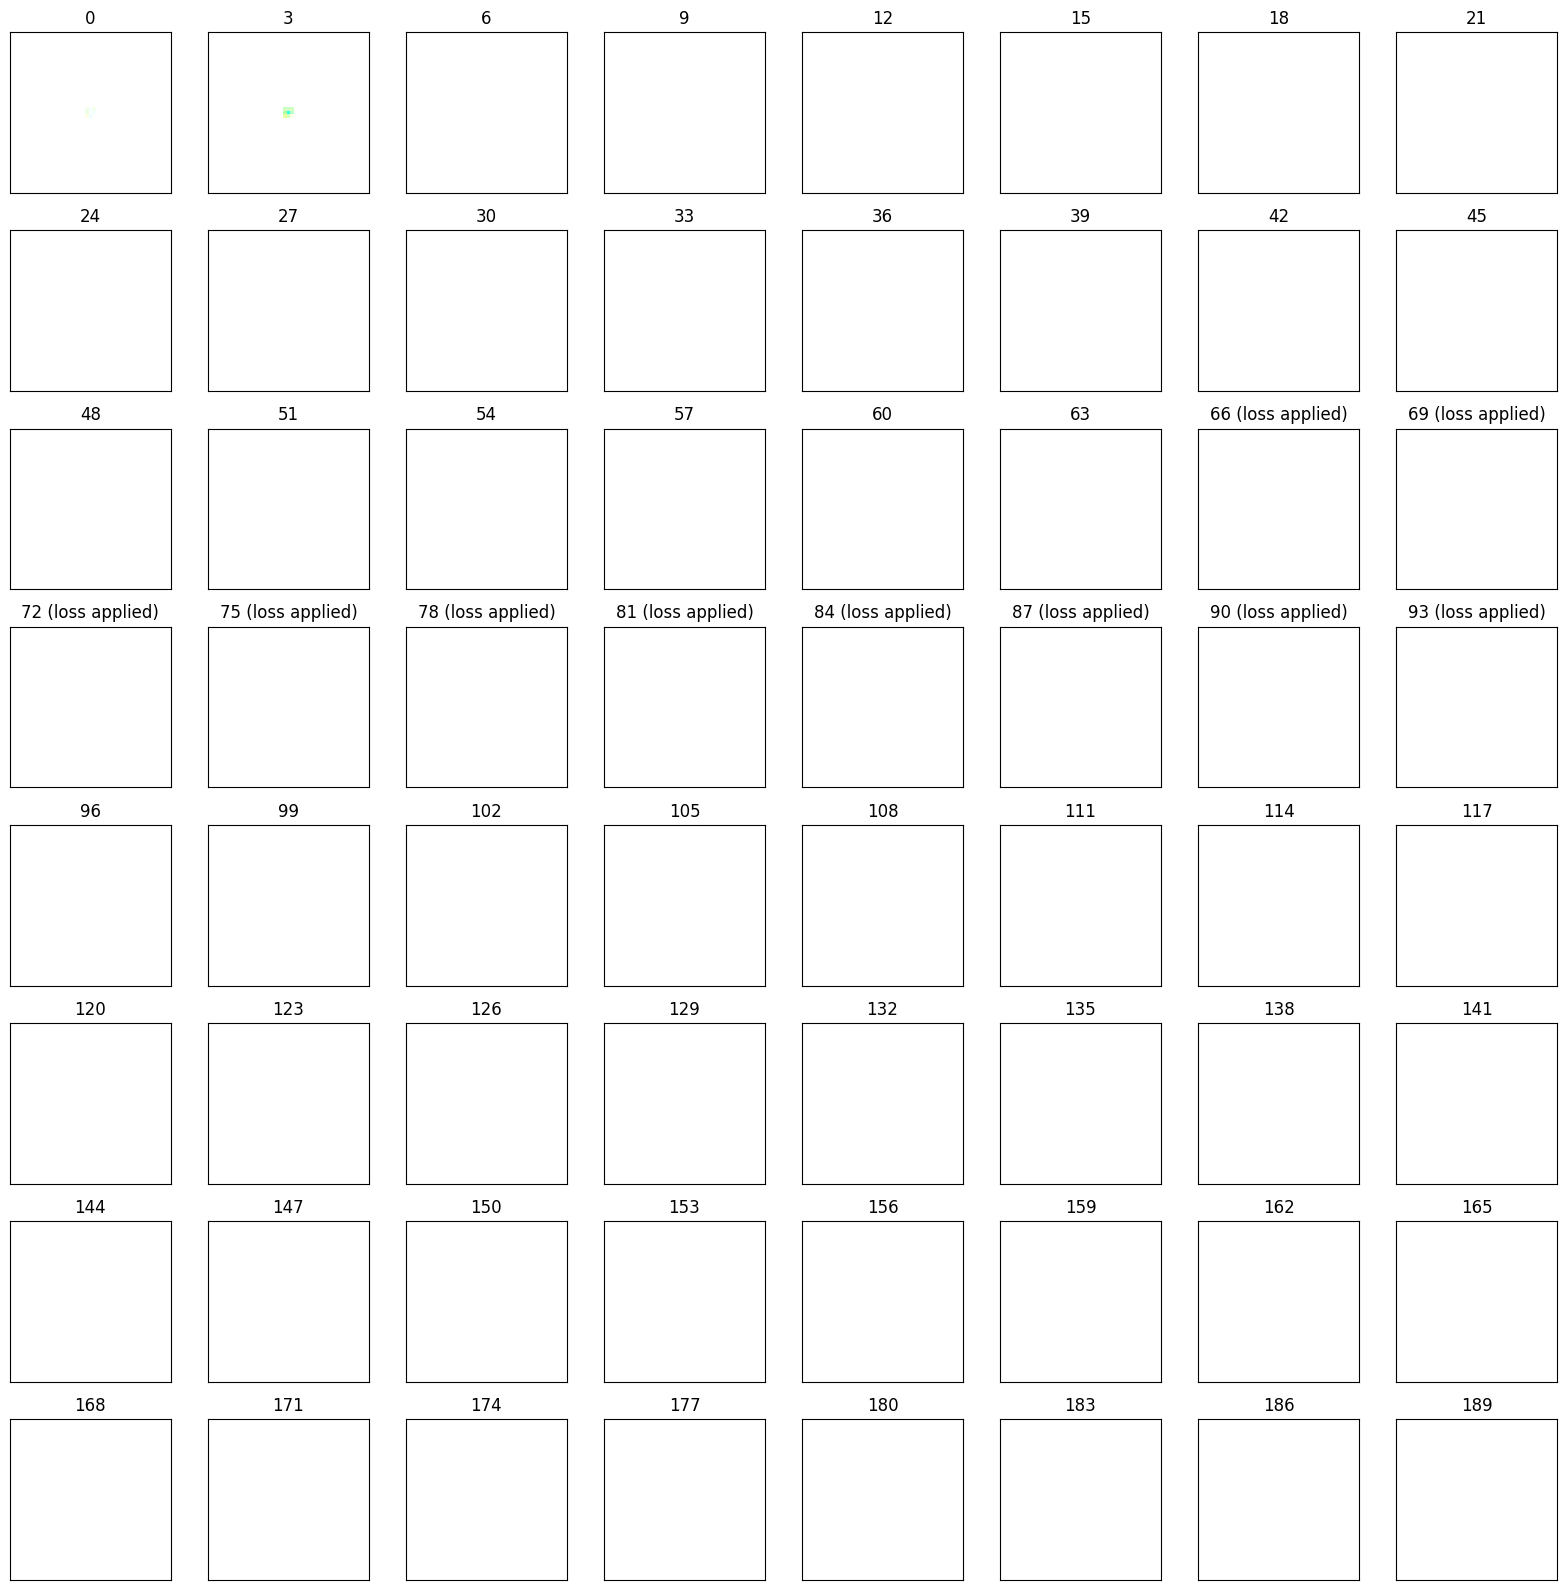

In [17]:
def zoom(x, k=14):
  return x[...,k:-k,k:-k]

def to_rgb(x):
  rgb, a = x[..., :3,:,:], x[..., 3:4,:,:].clip(0,1)
  return 1.0-a+rgb  # assume rgb premultiplied by alpha
  
# Visualize the dynamics of our learned CA
data = get_dataset(filenumber=10)
init_state = torch.zeros(1, args.state_dim, *data['y'].shape[-2:])
init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.

plot_every = 3
frames = model.cpu()(init_state, 200).detach().numpy()
frames = zoom(to_rgb(frames))[::plot_every]

rows, cols = 8, 8
fig = plt.figure(figsize=[2*cols, 2*rows], dpi=100)
for i in range(rows):
  for j in range(cols):
    ix = 1 + i*cols + j
    if frames.shape[0] >= ix:
      plt.subplot(rows,cols,ix)
      plt.xticks([],[]) ; plt.yticks([],[])
      plt.title(plot_every*(ix-1))
      if plot_every*(ix-1) > args.num_steps[0] and plot_every*(ix-1) < args.num_steps[1]:
        plt.title('{} (loss applied)'.format(plot_every*(ix-1)))
      plt.imshow(frames[ix-1,0].transpose(1,2,0).clip(0,1))

plt.tight_layout() ; plt.show()